# LIBRARIES

In [1]:
import pickle
from Environment import Environment
from UserCat import UserCat
from Product import Product
from Greedy_optimizer import *
import numpy as np
import matplotlib.pyplot as plt
from ucb1_brute_force import *
from ucb1_greedy import *

# Expected Reward test

In [2]:
# environment
users=[]
products=[]

#name of products
nameofproduct= [
    "Calabazas",
    "Hinojo",
    "Sesamo",
    "Girasol"
]

prices = [[4., 6, 7, 8], 
          [9., 13, 17, 21], 
          [18., 20, 22, 24], 
          [24., 26, 28, 30]]
#1-2 di delta, Con sovrapposizione

cost=[2,4.5,9,14]

#sarebbe interessante anche prendere da file il tutto così da cambiare tutto più facilmente
#calcolo i margini dai cost mi sembra più sensato e anche più veloce se dobbiamo cambiare continuamente

cost2 = np.tile(np.array([cost]).transpose(), (1, 4))
margins = np.array(prices)-cost2

Secondary_dict={"Calabazas": [1,2], 
                "Hinojo": [0,2], 
                "Sesamo": [1,3], 
                "Girasol": [1,2]}
# media è shape*scale, la varianza è shape*scale^2
res_price_params = {"shape": 150, 
                    "scale": 0.2, 
                    "max" : 60, 
                    "min" : 5}

np.random.seed(1)
probabilities = [[0, 0.3, 0.2, 0],
                 [0.3, 0, 0.3, 0],
                 [0, 0.2, 0, 0.4],
                 [0, 0.2, 0.3, 0]]
probabilities = np.matrix(probabilities)


alphas=[1/5, 1/5, 1/5, 1/5, 1/5] 
# per ora li generiamo così, tutti uguali -> devo generare 3 diversi vettori alpha

poisson_lambda = 0.7
#=valore atteso del numero di prodotti acquistati (specifico per prodotto)...non dipende dal
#prodotto oltre che dallo user che dal tipo di user che

# p_users = [4/9, 3/9, 2/9] #probabilità di essere un tipo di utente-> da cambiare
p_users = [1]

lambda_q = 0.5 #just my idea of lambda
#possiamo stimarlo con i dati passati provenienti dal sito -> vino tot è stato comprato 15 volte

#proviamo a pensare, ha senso vederlo come coppia? categoria-prodotto? Avrei 3 categorie *5 prodotti-> 15 lambda diversi
# ^^ Andre: secondo me ha senso avere 3 lambda_q diversi per categoria MA non per prodotto. La probabilità di continuare
#           a guardare secondo me dipende dall'utente e non dal prodotto

for i in range (4):
    products.append(Product(prices[i], i, nameofproduct[i],margins[i]))

# for i in range(3):
users.append(UserCat(alphas, res_price_params, poisson_lambda, probabilities))

Env_prova = Environment(users, products,  lambda_q, Secondary_dict, p_users)

# CASI POSSIBILI
# Guardare documento word su trello nella scheda TEST EXPECTED REWARD
# 0 a): b0*(1-q01)*(1-q02)*m0 
# 0 b) : b0*q01*(1-b1)*[(1-q02)+q02*(1-b2)]*m0
# 0-1 a) :b0*q01*b1*q12*(1-b2)*[m0+m1]
# 0-1 b): b0*q01*b1*(1-q12)*[(1-q02)+q02*(1-b2)]*[m0+m1]
# 0-2 a): b0*(1-q01)*q02*b2*{(1-q21)*(1-q23)+ q21*(1-b1)*[(1-q23) + q23*(1-b3)]}*[m0+m2]
# 0-2 b) : b0*q01*(1-b1)*q02*b2*[q23*(1-b3)+(1-q23)]* [m0+m2]
# 0-1-2 a): b0*q01*b1*q12*b2*[q23*(1-b3)*(1-q23)] *[m0+m1+m2]
# 0-1-2 b): b0*q01*b1*(1-q12)*(q02)*b2*[q23*(1-b3)*(1-q23)] *[m0+m1+m2]
# 0-1-2-3 a) : b0*q01*b1*q12*b2*q23*b3*[m0+m1+m2+m3]
# 0-1-2-3 b) : b0*q01*b1*(1-q12)*q02*b2*q23*b3*[m0+m1+m2+m3]
# 0-2-3 a) : b0*q01*(1-b1)*q02*b2*q23*b3*[m0+m2+m3]
# 0-2-3 b) : b0*(1-q01)*q02*b2*q21*(1-b1)*q23*b3*[m0+m2+m3]
# 0-2-3 c) : b0*(1-q01)*q02*b2*(1-q21)*q23*b3*[q31*(1-b1)+(1-q31)] *[m0+m2+m3]
# 0-2-3-1 : b0*(1-q01) *q02*b2*q23*b3*q31*b1[m0+m1+m2+m3]
# 0-2-1 : b0*(1-q01)*q02*b2*q12*b1*[q23*(1-b23)+(1-q23)]*[m0+m1+m2]

# definisco i valori teorici
b0 = Env_prova.theoretical_values["conversion_rates"][0][0][0]
b1 = Env_prova.theoretical_values["conversion_rates"][0][1][0]
b2 = Env_prova.theoretical_values["conversion_rates"][0][2][0]
b3 = Env_prova.theoretical_values["conversion_rates"][0][3][0]

q01 = Env_prova.theoretical_values["graph_weights"][0][0,1]
q02 = lambda_q * Env_prova.theoretical_values["graph_weights"][0][0,2]
q10 = Env_prova.theoretical_values["graph_weights"][0][1,0]
q12 = lambda_q * Env_prova.theoretical_values["graph_weights"][0][1,2]
q21 = Env_prova.theoretical_values["graph_weights"][0][2,1]
q23 = lambda_q * Env_prova.theoretical_values["graph_weights"][0][2,3]
q31 = Env_prova.theoretical_values["graph_weights"][0][3,1]
q32 = lambda_q * Env_prova.theoretical_values["graph_weights"][0][3,2]

m0 = margins[0,0] * Env_prova.theoretical_values["n_prod_sold"][0]
m1 = margins[1,0] * Env_prova.theoretical_values["n_prod_sold"][0]
m2 = margins[2,0] * Env_prova.theoretical_values["n_prod_sold"][0]
m3 = margins[3,0] * Env_prova.theoretical_values["n_prod_sold"][0]

theoretical_reward = ( b0*(1-q01)*(1-q02)*m0 + b0*q01*(1-b1)*((1-q02)+q02*(1-b2))*m0 + b0*q01*b1*q12*(1-b2)*(m0+m1) +
b0*q01*b1*(1-q12)*((1-q02)+q02*(1-b2))*(m0+m1) + b0*(1-q01)*q02*b2*((1-q21)*(1-q23)+ q21*(1-b1)*((1-q23) + q23*(1-b3)))*(m0+m2) +
b0*q01*(1-b1)*q02*b2*(q23*(1-b3)+(1-q23))* (m0+m2) + b0*q01*b1*q12*b2*(q23*(1-b3)*(1-q23)) *(m0+m1+m2) + 
b0*q01*b1*(1-q12)*(q02)*b2*(q23*(1-b3)*(1-q23)) *(m0+m1+m2) + b0*q01*b1*q12*b2*q23*b3*(m0+m1+m2+m3) +
b0*q01*b1*(1-q12)*q02*b2*q23*b3*(m0+m1+m2+m3) + b0*(1-q01)*q02*b2*q21*(1-b1)*q23*b3*(m0+m2+m3) +
b0*(1-q01)*q02*b2*(1-q21)*q23*b3*(q31*(1-b1)+(1-q31))*(m0+m2+m3) + b0*(1-q01) *q02*b2*q23*b3*q31*b1*(m0+m1+m2+m3)+
b0*(1-q01)*q02*b2*q12*b1*(q23*(1-b3)+(1-q23))*(m0+m1+m2) )

product = products[0]
price_combination = [0, 0, 0, 0]
user_index = 0

Env_prova.expected_reward(price_combination)

paths_list = []
Env_prova.explore_path(paths_list, None, 0, price_combination, 0)
algo_reward = 0. 
for path in paths_list:
    algo_reward += path.expected_return()
algo_reward

algo_reward2 = Env_prova.product_reward(product, [], [0], [Product([], -1, "null", [])], price_combination, user_index)
print("theoretical reward :", theoretical_reward)
print("path reward :", algo_reward)
print("old reward :", algo_reward2)

theoretical reward : 6.786367931533913
path reward : 8.44432783177496
old reward : 8.015746130857606


In [3]:
for path in paths_list:
    print(path)

primary seen : [0]
primary bought : []
probability : 0.0
collected_margin : 0

primary seen : [0, 1, 2]
primary bought : [0]
probability : 0.0
collected_margin : 3.4

primary seen : [0, 1, 2, 3]
primary bought : [0, 2]
probability : 0.0
collected_margin : 18.7

primary seen : [0, 1, 2, 3]
primary bought : [0, 2, 3]
probability : 0.0
collected_margin : 35.7

primary seen : [0, 1, 2]
primary bought : [0, 2]
probability : 0.0
collected_margin : 18.7

primary seen : [0, 1]
primary bought : [0]
probability : 0.0
collected_margin : 3.4

primary seen : [0, 1, 2]
primary bought : [0, 1]
probability : 2.1578860698312496e-10
collected_margin : 11.049999999999999

primary seen : [0, 1, 2, 3]
primary bought : [0, 1, 2]
probability : 4.107097154041313e-05
collected_margin : 26.349999999999998

primary seen : [0, 1, 2, 3]
primary bought : [0, 1, 2, 3]
probability : 0.008958928985301866
collected_margin : 43.349999999999994

primary seen : [0, 1, 2]
primary bought : [0, 1, 2]
probability : 0.03599999

# TESTING of ENVIRONMENT.py

In [4]:
np.random.seed(1)

users = []
products=[]

#name of products
nameofproduct = ["Calabazas", 
                 "Hinojo", 
                 "Sesamo", 
                 "Girasol", 
                 "Amapola"]

prices = [[4., 5, 6, 7], 
          [6., 7, 8, 9], 
          [9., 10, 11, 12], 
          [10., 11, 12, 13], 
          [12., 13, 14, 15]]
#1-2 di delta, Con sovrapposizione

cost = [3, 5, 7, 8 ,9]

#sarebbe interessante anche prendere da file il tutto così da cambiare tutto più facilmente
#calcolo i margini dai cost mi sembra più sensato e anche più veloce se dobbiamo cambiare continuamente

cost2 = np.tile(np.array([cost]).transpose(), (1, 4))
margins = np.array(prices)-cost2

Secondary_dict={"Calabazas": [1,4], 
                "Hinojo": [2,0], 
                "Sesamo": [0,3], 
                "Girasol": [4,1], 
                "Amapola": [3,2]}
# media è shape*scale, la varianza è shape*scale^2
res_price_params = {"shape": 4, 
                    "scale": 2.5}

probabilities = [[0, 1, 0, 0, 1],
                 [1, 0, 1, 0, 0],
                 [1, 0, 0, 1, 0],
                 [0, 1, 0, 0, 1],
                 [0, 0, 1, 1, 0]]
probabilities = np.matrix(probabilities)

alphas=[10, 10, 10, 10, 10] 
# per ora li generiamo così, tutti uguali -> devo generare 3 diversi vettori alpha

poisson_lambda = 2
#=valore atteso del numero di prodotti acquistati (specifico per prodotto)...non dipende dal
#prodotto oltre che dallo user che dal tipo di user che

# p_users = [4/9, 3/9, 2/9] #probabilità di essere un tipo di utente-> da cambiare
p_users = [1]

lambda_q = 1
#possiamo stimarlo con i dati passati provenienti dal sito -> vino tot è stato comprato 15 volte

#proviamo a pensare, ha senso vederlo come coppia? categoria-prodotto? Avrei 3 categorie *5 prodotti-> 15 lambda diversi
# ^^ Andre: secondo me ha senso avere 3 lambda_q diversi per categoria MA non per prodotto. La probabilità di continuare
#           a guardare secondo me dipende dall'utente e non dal prodotto

for i in range (5):
    products.append(Product(prices[i], i, nameofproduct[i],margins[i]))

# for i in range(3):
users.append(UserCat(alphas, res_price_params, poisson_lambda, probabilities))

Env = Environment(users, products,  lambda_q, Secondary_dict, p_users)

In [5]:
Env.expected_reward(price_combination = [3, 3, 3, 1, 0])

11.522159461957445

In [6]:
Env.optimal_reward()

(11.943876187281173, [3, 2, 1, 1, 0])

In [7]:
a = Env.simulate_day(2000, [0,0,0,0,0], ["conversion_rates", "alpha_ratios", "products_sold", "graph_weights"])
a

{'CR_vector': array([[1220., 1134.,  933.,  856.,  644.],
        [1256., 1271., 1284., 1048., 1648.]]),
 'alpha_ratios': array([0.278 , 0.1365, 0.162 , 0.112 , 0.3115]),
 'n_prod_sold': array([3.04505701, 2.98145519, 2.98389085, 2.91001273, 2.90678716]),
 'graph_weights': array([[0.        , 0.99998703, 0.        , 0.        , 0.99998459],
        [0.99985716, 0.        , 0.99998868, 0.        , 0.        ],
        [0.99998413, 0.        , 0.        , 0.99997753, 0.        ],
        [0.        , 0.99995595, 0.        , 0.        , 0.9999734 ],
        [0.        , 0.        , 0.99987015, 0.99997362, 0.        ]])}

In [8]:
np.matrix(Env.theoretical_values["conversion_rates"][0])

matrix([[0.92118651, 0.85712346, 0.77872291, 0.69193743],
        [0.77872291, 0.69193743, 0.60251972, 0.51521611],
        [0.51521611, 0.43347012, 0.35944777, 0.29422992],
        [0.43347012, 0.35944777, 0.29422992, 0.2380655 ],
        [0.29422992, 0.2380655 , 0.19062241, 0.15120388]])

# Greedy Algorithm Test

In [9]:
greedy_optimizer = Greedy_optimizer(Env)
greedy_optimizer.run()

{'combination': [3, 2, 1, 1, 0], 'expected_reward': 11.943876187281173}

In [10]:
opt_reward = greedy_optimizer.run()['expected_reward']

# STEP 3 : Uncertain Convertion Rates

In [11]:
from step3_learner import TS_learner3

In [12]:
# Initial assumptions for beta parameters (uniform distr. on [0, 1])
a = np.ones((5,4))
b = np.ones((5,4))
initial_beta = [a, b]
learner = TS_learner3(initial_beta, Env)

In [ ]:
n_runs = 100
daily_users = 200
n_days = 1000

# delete possible old reward_history
learner.reward_history = []

learner.run(n_days, daily_users)

for i in range(n_runs) :
    learner.run(n_days, daily_users)

opt_reward = learner.opt_reward
collected_rewards = learner.reward_history

- ## Salvo la history su file in modo che siamo sicuri ti riuscire a recuperarla anche in un secondo momento

In [ ]:
with open('step3_rewards', 'wb') as f: 
    pickle.dump(collected_rewards, f)

- ## Per recuperare, invece, i risultati ottenuti in un secondo momento :

In [13]:
with open('step3_rewards', 'rb') as f: 
    collected_rewards = pickle.load(f)

- ## Cumulative Regret Plot

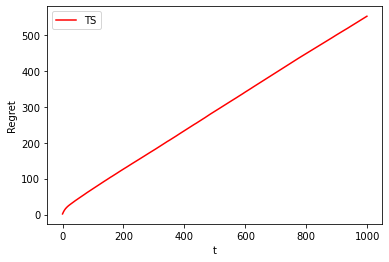

In [14]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt_reward - collected_rewards, axis=0)), 'r')  #'r' stay for red, the color for the TS algorithm
#plt.plot(np.cumsum(np.mean(opt - gr_rewards_per_experiment, axis=0)), 'g') #'g' stay for green, the color for the Greedy algorithm
plt.legend(["TS"])
plt.show()

- ## Standard Deviation Plot

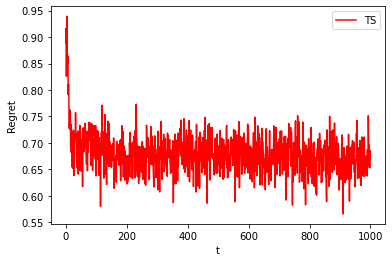

In [15]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.std(opt_reward - collected_rewards, axis=0), 'r')  #'r' stay for red, the color for the TS algorithm
#plt.plot(np.std(opt - gr_rewards_per_experiment, axis=0), 'g')  #'g' stay for green, the color for the Greedy algorithm
plt.legend(["TS"])
plt.show()

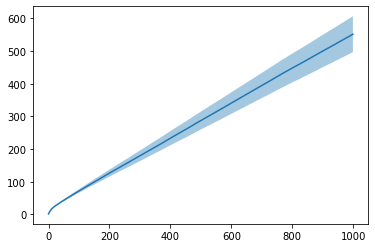

In [18]:
# mean_R = np.mean(R, axis=0)
cum_R = np.cumsum(opt_reward - collected_rewards, axis = 1)
mean_cum_R = np.mean(cum_R, axis = 0)
std_dev = np.std(cum_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_cum_R)
plt.fill_between(range(n_days), mean_cum_R-std_dev, mean_cum_R+std_dev, alpha=0.4)

- ## Comparison between Optimal and Expected Reward

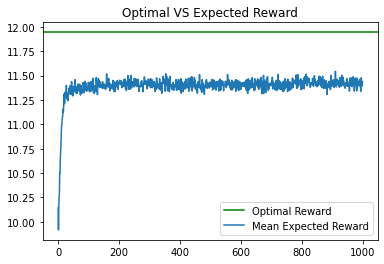

In [19]:
plt.figure(0)
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Expected Reward"])
plt.show()

## Explore the istant regret in the collected runs of the step 3 learner

In [20]:
opt_reward = learner.opt_reward
(opt_reward - collected_rewards)[2][-40:]

array([0.15688612, 0.15688612, 0.15688612, 0.15688612, 0.15688612,
       0.8549016 , 0.15688612, 0.15688612, 0.15688612, 0.15688612,
       0.15688612, 0.15688612, 0.15688612, 0.15688612, 0.15688612,
       0.15688612, 0.15688612, 0.15688612, 0.15688612, 0.15688612,
       0.15688612, 0.15688612, 0.15688612, 0.15688612, 0.15688612,
       0.15688612, 0.15688612, 0.15688612, 0.15688612, 0.15688612,
       0.15688612, 0.15688612, 0.15688612, 0.15688612, 0.15688612,
       0.15688612, 0.15688612, 0.15688612, 0.15688612, 0.15688612])

In [ ]:
learner.beta_parameters

In [ ]:
learner.sample_CR()

In [23]:
np.matrix(Env.theoretical_values['conversion_rates'][0])

matrix([[0.92118651, 0.85712346, 0.77872291, 0.69193743],
        [0.77872291, 0.69193743, 0.60251972, 0.51521611],
        [0.51521611, 0.43347012, 0.35944777, 0.29422992],
        [0.43347012, 0.35944777, 0.29422992, 0.2380655 ],
        [0.29422992, 0.2380655 , 0.19062241, 0.15120388]])

- ### ucb1 (with greedy optimizer)

In [ ]:
ucb1_greedy_R = []
ucb1g_collected_rewards = []
for _ in range(n_runs):
    ucb_greedy = ucb1_greedy(len(prices), len(prices[0]), prices, Env)
    instant_regret = []
    ucb1g_collected_rewards_temp = []
    for t in range(n_days):
        pulled_arms = ucb_greedy.pull_arms()
        estimated_CR = Env.simulate_day(daily_users, pulled_arms, ["conversion_rates"])['CR_vector']
        ucb_greedy.update(pulled_arms, estimated_CR)
        reward = Env.expected_reward(pulled_arms)
        ucb1g_collected_rewards_temp.append(reward)
        instant_regret.append(opt_reward - reward)
    ucb1g_collected_rewards.append(ucb1g_collected_rewards_temp)
    cumulative_regret = np.cumsum(instant_regret)
    ucb1_greedy_R.append(cumulative_regret)

In [ ]:
# store the result
with open("ucb1_greedy_R", 'wb') as f1:
    pickle.dump(ucb1_greedy_R, f1)
with open("ucb1g_collected_rewards", 'wb') as f1:
    pickle.dump(ucb1g_collected_rewards, f1)

In [24]:
# load the result
with open("ucb1_greedy_R", 'rb') as f1:
    ucb1_greedy_R = pickle.load(f1)
with open("ucb1g_collected_rewards", 'rb') as f1:
    ucb1g_collected_rewards = pickle.load(f1)

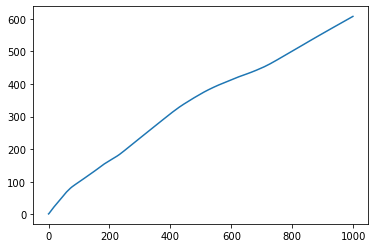

In [25]:
# plot of the result
mean_ucbg_R = np.mean(ucb1_greedy_R, axis=0)
std_dev_ucbg = np.std(ucb1_greedy_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_ucbg_R)
plt.fill_between(range(n_days), mean_ucbg_R-std_dev_ucbg, mean_ucbg_R+std_dev_ucbg, alpha=0.4)

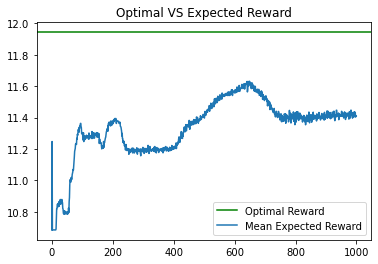

In [26]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(ucb1g_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Expected Reward"])
plt.show()

- ### ucb1 (brute force approach)

In [ ]:
n_runs = 2

ucb1_bforce_R = []
ucb1bf_collected_rewards = []
for _ in range(n_runs):
    ucb_brute_force = ucb1_brute_force(len(prices), len(prices[0]), prices, Env)
    instant_regret = []
    ucb1bf_collected_rewards_temp = []
    for t in range(n_days):
        pulled_arms = ucb_brute_force.pull_arms()
        estimated_CR = Env.simulate_day(daily_users, pulled_arms, ["conversion_rates"])['CR_vector']
        ucb_brute_force.update(pulled_arms, estimated_CR)
        reward = Env.expected_reward(pulled_arms)
        ucb1bf_collected_rewards_temp.append(reward)
        instant_regret.append(opt_reward - reward)
    ucb1bf_collected_rewards.append(ucb1bf_collected_rewards_temp)
    cumulative_regret = np.cumsum(instant_regret)
    ucb1_bforce_R.append(cumulative_regret)

In [ ]:
# store the result
with open("ucb1_bforce_R", 'wb') as f1:
    pickle.dump(ucb1_bforce_R, f1)
with open("ucb1bf_collected_rewards", 'wb') as f1:
    pickle.dump(ucb1bf_collected_rewards, f1)

In [27]:
# load the result
with open("ucb1_bforce_R", 'rb') as f1:
    ucb1_bforce_R = pickle.load(f1)
with open("ucb1bf_collected_rewards", 'rb') as f1:
    ucb1bf_collected_rewards = pickle.load(f1)

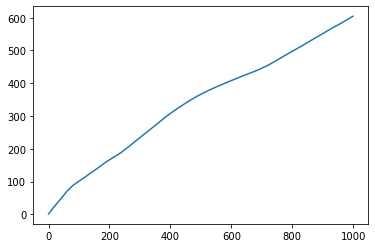

In [28]:
# plot of the result
mean_ucbbf_R = np.mean(ucb1_bforce_R, axis=0)
std_dev_ucbbf = np.std(ucb1_bforce_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_ucbbf_R)
plt.fill_between(range(n_days), mean_ucbbf_R-std_dev_ucbbf, mean_ucbbf_R+std_dev_ucbbf, alpha=0.4)

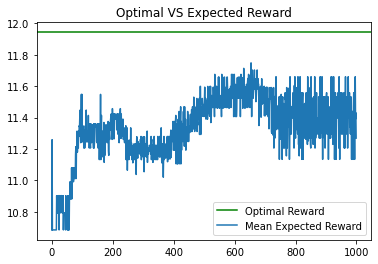

In [29]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(ucb1bf_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Expected Reward"])
plt.show()